In [1]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import time
import torch

from quantization_utils import (
    n1, n2, b1, b2, half_range_b2, half_range, generate_data, interval_based_quantize, interval_based_quantize_dequantize,
    interval_based_quantize_eachprint, interval_based_quantize_map, 
    dynamic_quantize_level_reduce, dynamic_quantize_level_reduce_dequantize, map_to_target_range
)

from distribution import (
    generate_single_peak_data, generate_double_peak_data,
    generate_uniform_data, generate_exponential_data,
    generate_multi_peak_data, generate_triangular_data,
    generate_poisson_data, generate_extreme_values_data,
    generate_gaussian_with_uniform_noise
)

In [2]:
# def dynamic_quantize_level_reduce(Q, D, num_levels):
#     unique_levels = torch.unique(Q)  # 提取 Q 中的唯一值
#     unique_levels.sort()  # 排序
#     iteration = 0  # 初始化循环计数器
#     hist_data = []  # 用于保存每一步的直方图数据

#     while len(unique_levels) > num_levels:
#         iteration += 1  # 循环次数加一
#         total_errors = {}  # 用于保存去除每个 level 后的误差总和

#         # 遍历每个 level，计算去掉该 level 后的误差总和
#         for level in unique_levels:
#             # 创建一个副本，在副本中移除当前级别的元素
#             Q_copy = Q.clone()

#             # 获取当前级别在 unique_levels 中的索引位置
#             level_idx = torch.where(unique_levels == level)[0].item()

#             # 根据索引位置将当前级别的值重新分配给相邻的级别
#             if level_idx == 0:
#                 # 如果是第一个量化级别，重新分配到下一个级别
#                 Q_copy[Q == level] = unique_levels[1]
#             elif level_idx == len(unique_levels) - 1:
#                 # 如果是最后一个量化级别，重新分配到上一个级别
#                 Q_copy[Q == level] = unique_levels[-2]
#             else:
#                 # 否则，分配到相邻的两个级别，根据原始数据 D 的距离进行分配
#                 less_level = unique_levels[level_idx - 1].item()
#                 more_level = unique_levels[level_idx + 1].item()
#                 Q_copy[(Q == level) & (D <= level)] = less_level
#                 Q_copy[(Q == level) & (D > level)] = more_level

#             # 计算去除当前级别后的误差总和
#             E_copy = (Q_copy - D) ** 2
#             total_errors[level.item()] = E_copy.sum().item()

#         # 找到移除后误差总和最小的量化级别
#         level_to_remove = min(total_errors, key=total_errors.get)
#         print(f"Iteration {iteration}: Removing level {level_to_remove} with total error {total_errors[level_to_remove]}")

#         # 移除误差最小的 level 并重新分配 Q 中对应的元素
#         level_idx_to_remove = torch.where(unique_levels == level_to_remove)[0].item()

#         if level_idx_to_remove == 0:
#             Q[Q == level_to_remove] = unique_levels[1]
#         elif level_idx_to_remove == len(unique_levels) - 1:
#             Q[Q == level_to_remove] = unique_levels[-2]
#         else:
#             less_level = unique_levels[level_idx_to_remove - 1].item()
#             more_level = unique_levels[level_idx_to_remove + 1].item()
#             Q[(Q == level_to_remove) & (D <= level_to_remove)] = less_level
#             Q[(Q == level_to_remove) & (D > level_to_remove)] = more_level


#         # 打印出被替换的level的值
#         print(f"less_level: {less_level}, more_level: {more_level}")
        
#         # 更新唯一值
#         unique_levels = torch.unique(Q)
#         unique_levels.sort()  # 排序

#         # 将当前的量化数据 Q 从[0, b1-1]映射到 [-b2 / 2, b2 / 2 - 1] 区间
#         Q_mapped = map_to_target_range(Q, 0, b1 - 1, -half_range(num_levels), half_range(num_levels) - 1)

#         # 保存映射后的直方图数据
#         hist_data.append(Q_mapped.clone().numpy())

#         # 打印出最小的误差，及其对应的level的值
#         print(f"min_level: {level_to_remove}, min_error: {total_errors[level_to_remove]}\n")
    
#     # # 全弄完之后，最后一次映射，将当前的量化数据 Q 从[0, b1-1]映射到 [-b2 / 2, b2 / 2 - 1] 区间
#     Q_mapped = map_to_target_range(Q, 0, b1 - 1, -half_range(num_levels), half_range(num_levels) - 1)

#     return Q_mapped, hist_data

Text(0, 0.5, 'Frequency')

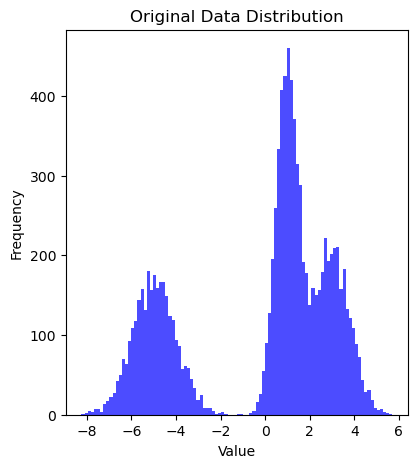

In [3]:
# 主程序
data = generate_data()  # 生成数据
#data = generate_uniform_data()  # 生成均匀分布数据

# 画图
plt.figure(figsize=(15, 5))  # 画布总的大小
# 先画原始数据分布图
plt.subplot(1, 3, 1)
plt.hist(data.numpy(), bins=100, color='blue', alpha=0.7)
plt.title("Original Data Distribution")
plt.xlabel("Value")
plt.ylabel("Frequency")

Text(0, 0.5, 'Frequency')

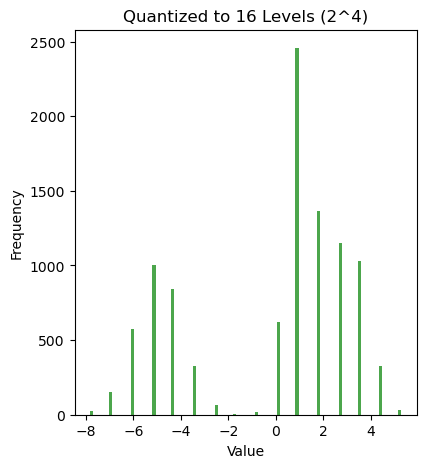

In [4]:
# 第一次量化
# quantized_data = quantize(data, b1)

quantized_data, dequantized_data = interval_based_quantize_dequantize(data, b1) # 使用基于区间的量化函数

# 第一次量化后的分布图
plt.figure(figsize=(15, 5))  # 画布总的大小
plt.subplot(1, 3, 2)
plt.hist(dequantized_data.numpy(), bins=100, color='green', alpha=0.7)
plt.title(f"Quantized to {b1} Levels (2^{n1})")
plt.xlabel("Value")
plt.ylabel("Frequency")
#plt.xlim(-half_range(b1), half_range(b1))


In [5]:
start_time = time.time()  # 记录开始时间

In [6]:
# 进行动态量化级别缩减
#quantized_data_second, hist_data = dynamic_quantize_level_reduce(quantized_data, data, b2)
quantized_data_second, hist_data = dynamic_quantize_level_reduce_dequantize(dequantized_data, data, b2)

# 进行均匀量化（全是均匀量化版）
#quantized_data_second, hist_data = interval_based_quantize_eachprint(quantized_data, b2)



Iteration 1:
Updated level_mapping: {-7.805543162714848: -7.805543162714848, -6.934094808006398: -6.934094808006398, -6.062646453297949: -6.062646453297949, -5.191198098589499: -5.191198098589499, -4.319749743881051: -4.319749743881051, -3.448301389172601: -3.448301389172601, -2.576853034464152: -2.576853034464152, -0.8339563250472533: -1.269680502401478, 0.037492029661196025: 0.037492029661196025, 0.9089403843696453: 0.9089403843696453, 1.7803887390780955: 1.7803887390780955, 2.651837093786544: 2.651837093786544, 3.5232854484949923: 3.5232854484949923, 4.394733803203442: 4.394733803203442, 5.266182157911892: 5.266182157911892}
Iteration 2:
Updated level_mapping: {-6.934094808006398: -7.369818985360623, -6.062646453297949: -6.062646453297949, -5.191198098589499: -5.191198098589499, -4.319749743881051: -4.319749743881051, -3.448301389172601: -3.448301389172601, -2.576853034464152: -2.576853034464152, -0.8339563250472533: -1.269680502401478, 0.037492029661196025: 0.037492029661196025, 0.

In [7]:
# 计算动态量化的最终损失（均方误差）
final_error_dynamic = ((quantized_data_second - data) ** 2).sum().item()
num_samples = data.size(0)
mean_squared_error_dynamic = final_error_dynamic / num_samples


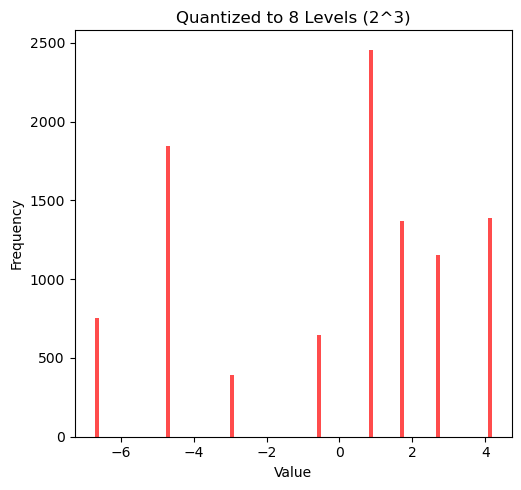

In [8]:
# 最终量化后分布图
plt.figure(figsize=(15, 5))  # 画布总的大小

plt.subplot(1, 3, 3)
plt.hist(quantized_data_second.numpy(), bins=100, color='red', alpha=0.7)
plt.title(f"Quantized to {b2} Levels (2^{n2})")
plt.xlabel("Value")
plt.ylabel("Frequency")
# # X轴的范围是-((b1 - 1) / 2), (b1 - 1) / 2
# plt.xlim(-half_range_b2, half_range_b2)

plt.tight_layout()
plt.show()

In [9]:
# # 不对不对这个一步到位了，不用gif

# # 动画绘制
# fig, ax = plt.subplots(figsize=(8, 6))
# ax.set_xlim(-half_range_b2, half_range_b2)
# ax.set_ylim(0, 5000)  # 设置适当的Y轴范围

# # 动画更新函数
# def update(frame):
#     ax.clear()
#     ax.hist(hist_data[frame], bins=100, color='red', alpha=0.7)
#     ax.set_title(f"Uniform Quantization Step: {frame + 1}")
#     ax.set_xlabel("Value")
#     ax.set_ylabel("Frequency")
#     ax.set_xlim(-half_range_b2, half_range_b2)
#     ax.set_ylim(0, 5000)  # 设置Y轴范围为0到5000

# # 创建动画
# ani = FuncAnimation(fig, update, frames=len(hist_data), repeat=False)

# # 保存为GIF文件
# ani.save('uniform_quantization_process.gif', writer='imagemagick', fps=1)

# # 显示生成的GIF文件路径
# print("GIF animation saved as 'uniform_quantization_process.gif'")

In [10]:
# 对比！
# ------------------------均匀量化--------------------------
# quantized_data_uniform = uniform_quantization(data, b2)
quantized_data_uniform, dequantized_data_uniform = interval_based_quantize_dequantize(data, b2) # 均匀量化
#quantized_data_uniform_mapped = map_to_target_range(quantized_data_uniform, 0, b1 - 1, -half_range_b2, half_range_b2)

# 计算均匀量化的最终损失（均方误差）
final_error_uniform_mapped = ((dequantized_data_uniform - data) ** 2).sum().item()
mean_squared_error_uniform_mapped = final_error_uniform_mapped / num_samples

In [11]:
# 打印时间和最终均方误差
minimization_time = time.time() - start_time
print(f"Minimization to {b2} levels took {minimization_time:.4f} seconds.")
print(f"Final Mean Squared Error (本算法): {mean_squared_error_dynamic:.4f}")
print(f"Final Mean Squared Error (均匀): {mean_squared_error_uniform_mapped:.4f}")

Minimization to 8 levels took 0.4497 seconds.
Final Mean Squared Error (本算法): 0.2302
Final Mean Squared Error (均匀): 0.2465
